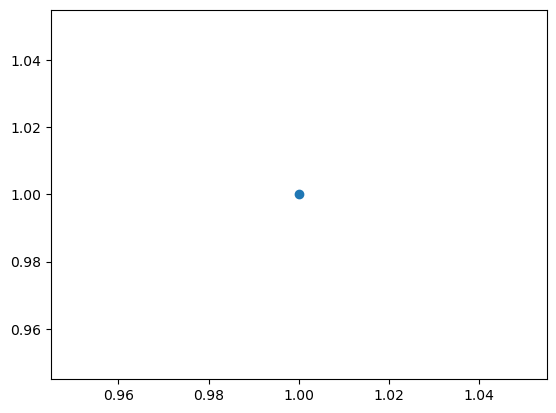

In [13]:
import matplotlib.pyplot as plt
plt.scatter(1,1)

In [14]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np

In [15]:
main_dir = 'SPORT_DATASET/'
train_dir = 'Train/'
test_dir = 'Test/'
class_names = os.listdir(os.path.join(main_dir, train_dir))

In [16]:
classes = len([x for x in os.walk(os.path.join(main_dir, train_dir))])
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(8)
        
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(16)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.fc6 = nn.Linear(1024, 1024)
        self.fc7 = nn.Linear(1024, 100)
        self.fc8 = nn.Linear(100, classes)
        
    def forward(self, X):
        
        X = self.conv1(X)
        X = self.conv1_bn(X)
        X = F.relu(X)
        X = self.pool(X)
              
        X = self.conv2(X)
        X = self.conv2_bn(X)
        X = F.relu(X)
        X = self.pool(X)
        
        X = X.view(-1, 1024)

        X = self.fc1(X)
        X = F.relu(X)
        Y = X
        Z = X
        
        X = self.fc2(X)
        X = F.relu(X)
        X = X + Y
        
        X = self.fc3(X)
        X = F.relu(X)
        Y = X
        
        X = self.fc4(X)
        X = F.relu(X)
        X = X + Y + Z
        
        X = self.fc5(X)
        X = F.relu(X)
        Y = X
        Z = X
        
        X = self.fc6(X)
        X = F.relu(X)
        X = X + Y 
        
        X = self.fc7(X)
        X = F.relu(X)
        
        X = self.fc8(X)
        X = F.sigmoid(X)
        return X

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
NAME = 'SPORT_1'
epoche = 0
test_acc = None
best = 0
BEST_NET = None

In [18]:
def change_dl_params(train_data, batch_size):
    random_bg_color=tuple(np.random.randint((255,255,255)))
    train_transforms = transforms.Compose([#transforms.Pad([100*center_shift[0][0],
                                                           #100*(1-center_shift[0][1]),
                                                           #100*(1-center_shift[0][0]),
                                                           #100*center_shift[0][1]],fill=255),
                                       #transforms.CenterCrop((100,100)),
                                       transforms.Resize((32, 32)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0), scale=(0.7, 1.2), fill= random_bg_color),
                                       
                                       transforms.ToTensor()
                                      ])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
                                   
    return train_loader, train_transforms  

In [19]:
epochs = 10000
learning_rate = 0.00005

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), learning_rate, weight_decay=0.00001)

train_transforms = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0), scale=(0.7, 1.1), fill=255),
                                       transforms.ToTensor()
                                      ])
test_transforms = train_transforms

BATCH_SIZE = 8#len(test_data)

train_data = datasets.ImageFolder(os.path.join(main_dir, train_dir), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(main_dir, test_dir), transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)



In [20]:
for cur in range(epochs):
    epoche += 1
    
    obj_number = 0
    correct_obj = 0

    
    # new_loader, new_transformss = change_dl_params(train_data, BATCH_SIZE)
    # test_transforms = new_transformss
    # train_data = datasets.ImageFolder(os.path.join(main_dir, train_dir), transform=train_transforms)
    # test_data = datasets.ImageFolder(os.path.join(main_dir, test_dir), transform=test_transforms)

    
    for x, y in train_loader:
            
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        _, prediction = torch.max(outputs.data, 1)
        loss.backward()
        optimizer.step()
    
    
        
        obj_number += labels.size(0)
        correct_obj += (prediction == labels).sum().item()
    
        print(f"Эпоха: {epoche} , датасет пройден на {round(100*obj_number/len(train_data),2)}%, точность по обучающему {round(100*correct_obj/obj_number,2)}%, точность тестирования прошлой эпохи {round(100*test_acc,2) if test_acc else 0.00}%        ",
              sep='', end='\r')
    

    test_total = 0
    test_correct = 0    
    with torch.no_grad():
            for test_images, test_targets in test_loader:
    
                images, targets = test_images.to(device), test_targets.to(device)
                test_outputs = model(images)
                difference = criterion(test_outputs, targets)
                
                _, test_pred = torch.max(test_outputs.data, 1)
                test_total += targets.size(0)
                test_correct += (test_pred == targets).sum().item()
    to_comp = test_acc            
    test_acc = test_correct/test_total

    dynamic = test_acc - to_comp if to_comp else 0.0
    
    if cur == epochs - 1:
        print(f"Эпоха: {epoche} завершена, датасет пройден на {round(100*obj_number/len(train_data),2)}%, точность по обучающему {round(100*correct_obj/obj_number,2)}%, точность тестирования данной эпохи {round(100*test_acc,2) if test_acc else 0.00}% Δ{round(100*dynamic,2)}%        ",
              sep='', end='\r')

KeyboardInterrupt: 

В реальности это:  Apple 5


Модель дает прогноз:

Apple 5 с вероятностью 19.82 
Apple Golden 1 с вероятностью 7.29


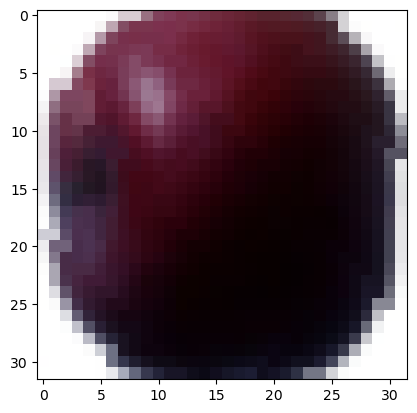

In [53]:
number = np.random.randint(len(test_data))

image, label = test_data[number]
image_np = np.array(image)
image_np = image_np.transpose((1, 2, 0))
plt.imshow(image_np)



pred = model(image.unsqueeze(0).to(device))

a = nn.Softmax(dim=0)(pred[0])
napas = torch.topk(a, 2, 0)

print("В реальности это: ", class_names[label])
print("\n\nМодель дает прогноз:\n")
print(f"{class_names[napas[1][0]]} с вероятностью {round(100 * float(napas[0][0]), 2)} \n{class_names[napas[1][1]]} с вероятностью {round(100 * float(napas[0][1]), 2)}")

Apple 5         	--- [134, 2, 12]
Cherry 1        	--- [158, 12, 6]
Blackberrie 1   	--- [143, 12, 7]
Apple Golden 1  	--- [136, 25, 24]
Pear 1          	--- [134, 4, 30]
Banana 1        	--- [114, 59, 52]
Apricot 1       	--- [160, 6, 4]
Tomato 1        	--- [239, 2, 7]
Trash           	--- [233, 114, 18]
Carrot 1        	--- [0, 0, 50]
Lemon 1         	--- [138, 0, 26]

F-score    -------------------------

Apple 5         	--- 0.99    0.92    	 0.9537172774869109
Cherry 1        	--- 0.93    0.96    	 0.9447619047619047
Blackberrie 1   	--- 0.92    0.95    	 0.93475935828877
Apple Golden 1  	--- 0.84    0.85    	 0.8449704142011835
Pear 1          	--- 0.97    0.82    	 0.8887150837988825
Banana 1        	--- 0.66    0.69    	 0.6746666666666665
Apricot 1       	--- 0.96    0.98    	 0.9698969072164948
Tomato 1        	--- 0.99    0.97    	 0.9798979591836734
Trash           	--- 0.67    0.93    	 0.7788750000000001
Carrot 1        	--- 0    0.0    	 0
Lemon 1         	--- 1.0    0.

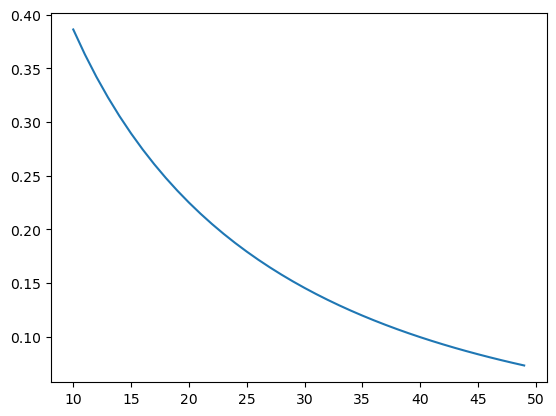

In [30]:
var = 1


try:
    if var ==1:
        best = WF
    elif var == 2:
        best = BF
    elif var == 3:
        best = S
except:
    pass

TP_FP_FN = dict()
for number in range(len(test_data)):
    image, label = test_data[number]
    val_pred = model(image.unsqueeze(0).to(device))
    pred_label = torch.topk(nn.Softmax(dim=0)(val_pred[0]), 2, 0)[1][0]
 
    if pred_label == label:
        if int(label) in TP_FP_FN:
            TP_FP_FN[int(label)][0] += 1
        else:
            TP_FP_FN[int(label)] = [1, 0, 0]
    else:
        if int(pred_label) in TP_FP_FN:
            TP_FP_FN[int(pred_label)][1] += 1
        else:
            TP_FP_FN[int(pred_label)] = [0, 1, 0]
            
        if int(label) in TP_FP_FN:
            TP_FP_FN[int(label)][2] += 1
        else:
            TP_FP_FN[int(label)] = [0, 0, 1]
for key in TP_FP_FN:
    print(class_names[key] + ' ' * (15-len(class_names[key])) ,'\t---',TP_FP_FN[key])
print('\nF-score    -------------------------\n')
Dobrot_f1 = []
for key in TP_FP_FN:
    print(class_names[key] + ' ' * (15-len(class_names[key])) ,'\t---',
          pc := round(TP_FP_FN[key][0] / (TP_FP_FN[key][0] + TP_FP_FN[key][1]) 
                if TP_FP_FN[key][0] + TP_FP_FN[key][1] > 0 else 0, 2),'  ',
          rc := round(TP_FP_FN[key][0] / (TP_FP_FN[key][0] + TP_FP_FN[key][2]) 
                if TP_FP_FN[key][0] + TP_FP_FN[key][2] > 0 else 0, 2),'  ','\t', f1 := 2 * (pc * rc) / (pc + rc) if (pc + rc) > 0 else 0)
    Dobrot_f1.append(f1)
print("\nСредний f-score: ", round(np.mean(Dobrot_f1), 3))


WF = min(Dobrot_f1)

BF = np.mean(Dobrot_f1)

Rigor = range(10,50)
A = []
for i in Rigor:
    A.append(np.mean([x**i for x in Dobrot_f1]))
plt.plot(Rigor, A)
S = 0
for i in range(len(A)-1):
    dS = (Rigor[i+1] - Rigor[i])*(A[i+1] + A[i])/2
    S += dS
print('\nПлощадь под кривой степеней f-score = ',S,'  \nЛучшее значение текущего критерия ',best)

if var ==1:
    CRIT = WF
elif var == 2:
    CRIT = BF
else:
    CRIT = S

if CRIT >= best: 
        torch.save(model, NAME)
        best = WF
else:
        model = torch.load(NAME, weights_only= 0)

In [ ]:
#torch.save(model, NAME)

In [28]:
def JUMP_NEXT_TO(epoche, model=model,test_acc = 0, best=best, pr = True, var = var):
    for cur in range(epoche):
        epoche += 1
        
        obj_number = 0
        correct_obj = 0
        
        for x, y in train_loader:
                
            inputs, labels = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
            _, prediction = torch.max(outputs.data, 1)
            loss.backward()
            optimizer.step()
        
        
            
            obj_number += labels.size(0)
            correct_obj += (prediction == labels).sum().item()
            if pr:
                print(f"Эпоха: {epoche} , датасет пройден на {round(100*obj_number/len(train_data),2)}%, точность по обучающему {round(100*correct_obj/obj_number,2)}%, точность тестирования прошлой эпохи {round(100*test_acc,2) if test_acc else 0.00}%        ",
                  sep='', end='\r')
        
    
        test_total = 0
        test_correct = 0    
        with torch.no_grad():
                for test_images, test_targets in test_loader:
        
                    images, targets = test_images.to(device), test_targets.to(device)
                    test_outputs = model(images)
                    difference = criterion(test_outputs, targets)
                    
                    _, test_pred = torch.max(test_outputs.data, 1)
                    test_total += targets.size(0)
                    test_correct += (test_pred == targets).sum().item()
        to_comp = test_acc            
        test_acc = test_correct/test_total
    
        dynamic = test_acc - to_comp if to_comp else 0.0
        
        if cur == epochs - 1:
            if pr:
                print(f"Эпоха: {epoche} завершена, датасет пройден на {round(100*obj_number/len(train_data),2)}%, точность по обучающему {round(100*correct_obj/obj_number,2)}%, точность тестирования данной эпохи {round(100*test_acc,2) if test_acc else 0.00}% Δ{round(100*dynamic,2)}%        ",
                  sep='', end='\r')
    TP_FP_FN = dict()
    if pr:
        print('\n')
    for number in range(len(test_data)):
        image, label = test_data[number]
        val_pred = model(image.unsqueeze(0).to(device))
        pred_label = torch.topk(nn.Softmax(dim=0)(val_pred[0]), 2, 0)[1][0]
     
        if pred_label == label:
            if int(label) in TP_FP_FN:
                TP_FP_FN[int(label)][0] += 1
            else:
                TP_FP_FN[int(label)] = [1, 0, 0]
        else:
            if int(pred_label) in TP_FP_FN:
                TP_FP_FN[int(pred_label)][1] += 1
            else:
                TP_FP_FN[int(pred_label)] = [0, 1, 0]
                
            if int(label) in TP_FP_FN:
                TP_FP_FN[int(label)][2] += 1
            else:
                TP_FP_FN[int(label)] = [0, 0, 1]
    for key in TP_FP_FN:
        if pr:
            print(class_names[key] + ' ' * (15-len(class_names[key])) ,'\t---',TP_FP_FN[key])
    if pr:        
        print('\nF-score    -------------------------\n')
    Dobrot_f1 = []
    for key in TP_FP_FN:
        if pr:
            print(class_names[key] + ' ' * (15-len(class_names[key])) ,'\t---',
              pc := round(TP_FP_FN[key][0] / (TP_FP_FN[key][0] + TP_FP_FN[key][1]) 
                    if TP_FP_FN[key][0] + TP_FP_FN[key][1] > 0 else 0, 2),'  ',
              rc := round(TP_FP_FN[key][0] / (TP_FP_FN[key][0] + TP_FP_FN[key][2]) 
                    if TP_FP_FN[key][0] + TP_FP_FN[key][2] > 0 else 0, 2),'  ','\t', f1 := 2 * (pc * rc) / (pc + rc) if (pc + rc) > 0 else 0)
            Dobrot_f1.append(f1)
        else:
            pc = round(TP_FP_FN[key][0] / (TP_FP_FN[key][0] + TP_FP_FN[key][1]) 
                    if TP_FP_FN[key][0] + TP_FP_FN[key][1] > 0 else 0, 2)
            rc = round(TP_FP_FN[key][0] / (TP_FP_FN[key][0] + TP_FP_FN[key][2]) 
                    if TP_FP_FN[key][0] + TP_FP_FN[key][2] > 0 else 0, 2)
            f1 = 2 * (pc * rc) / (pc + rc) if (pc + rc) > 0 else 0
            Dobrot_f1.append(f1)
    if pr:
        print("\nСредний f-score: ", round(np.mean(Dobrot_f1), 3))
    
    
    
    WF = min(Dobrot_f1)
    if var == 1:
        print("Худший единичный скор  - ", WF)
        return WF
        
    BF = np.mean(Dobrot_f1)
    if var == 2:
        print("Лучший средний скор  - ", BF)
        return BF
    
    S = 0
    Rigor = range(10,50)
    A = []
    if var == 3:
        for i in Rigor:
            A.append(np.mean([x**i for x in Dobrot_f1]))
        plt.plot(Rigor, A) 
        for i in range(len(A)-1):
            dS = (Rigor[i+1] - Rigor[i])*(A[i+1] + A[i])/2
            S += dS
        
        print('Лучшая площадь ',S)
        return S
    



att: 0/1000, текущий лучший - 0
Лучшая площадь  6.250356738915735


att: 1/1000, текущий лучший - 6.250356738915735
Лучшая площадь  3.6908696804900853


att: 2/1000, текущий лучший - 6.250356738915735
Лучшая площадь  2.614515651977786


att: 3/1000, текущий лучший - 6.250356738915735
Лучшая площадь  8.045179971425133


att: 4/1000, текущий лучший - 8.045179971425133
Лучшая площадь  7.513626870148739


att: 5/1000, текущий лучший - 8.045179971425133
Лучшая площадь  3.4098863745040204


att: 6/1000, текущий лучший - 8.045179971425133
Лучшая площадь  6.10542768236991


att: 7/1000, текущий лучший - 8.045179971425133
Лучшая площадь  7.360886286243974


att: 8/1000, текущий лучший - 8.045179971425133
Лучшая площадь  1.6344576403945885


att: 9/1000, текущий лучший - 8.045179971425133
Лучшая площадь  8.728667833134237


att: 10/1000, текущий лучший - 8.728667833134237
Лучшая площадь  1.105610913615362


att: 11/1000, текущий лучший - 8.728667833134237
Лучшая площадь  6.582773010567577


at

KeyboardInterrupt: 

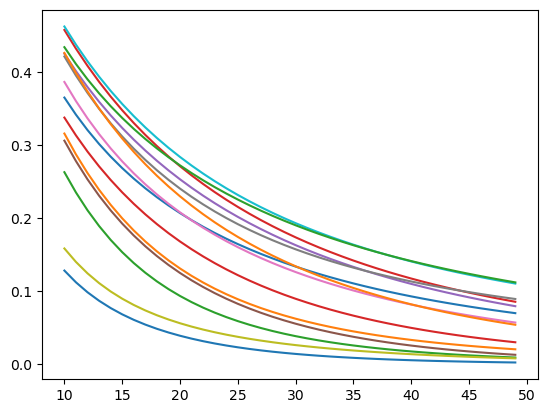

In [29]:
n = 1000
for att in range(n):
    print(f'\n\natt: {att}/{n}, текущий лучший - {best}')
    S = JUMP_NEXT_TO(1, pr=0,var=3)
    if S >= best: 
        torch.save(model, NAME)
        best = S
    else:
        model = torch.load(NAME, weights_only= 0)
    
print("Лучший результат ",best)

In [ ]:
#best = 0.94
#torch.save(model, NAME)